In [1]:
# import the necessary python modules
import numpy as np
import time
import corner
import matplotlib.pyplot as plt
import matplotlib
import os
import copy
import astropy.io.fits as pyfits


from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Plots.output_plots as lens_plot

from lenstronomy.Util import constants

from lenstronomy.ImSim.image_model import ImageModel

from lenstronomy.PointSource.point_source import PointSource

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

from lenstronomy.LightModel.light_model import LightModel

from lenstronomy.Sampling.parameters import Param

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

from lenstronomy.Cosmo.lens_cosmo import LensCosmo

from astropy.cosmology import FlatLambdaCDM

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import lenstronomy.Util.param_util as param_util
#DATOS RUNG-0

#### LENTE SPEMD #####
q = 0.787
phi=1.605
#Transformacion
e1, e2 = param_util.phi_q2_ellipticity(phi=phi, q=q)

#### LENTE LIGHT #####
ql=0.969
phil=1.731
#Transformacion
el1, el2 = param_util.phi_q2_ellipticity(phi=phil, q=ql)

#### SOURCE LIGHT ####
qs = 0.853
phis = 2.805
#Transformacion
es1, es2 = param_util.phi_q2_ellipticity(phi=phis, q=qs)

image positions are:  [ 1.30960709 -1.27082143  0.04583093 -0.10792881] [ 0.13134335 -0.13000975 -1.01968268  1.01242116]
point source magnification:  [ 2.38286358  2.49730141 -1.48339757 -1.47957516]
source size in arcsec:  0.0012076737527600947
finite magnification:  [2.382878   2.49732028 1.48341423 1.47959185]
time delays:  [-168.20146518 -158.84954655 -103.49468661 -103.30633627]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log10


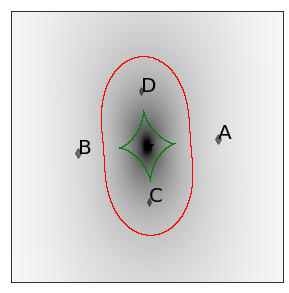

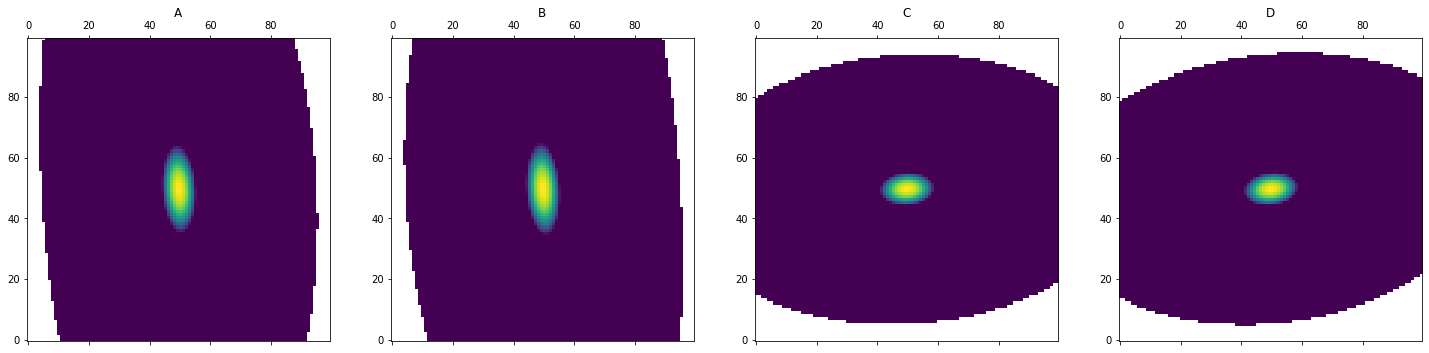

In [4]:
# the redshifts of lens and source and the cosmology is only used when predicting the relative time delays between the images
z_lens = 0.858
z_source = 2.175

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source)


# make class instances for a chosen lens model type

# chose a lens model
lens_model_list = ['SPEP', 'SHEAR']
# make instance of LensModel class
lensModel = LensModel(lens_model_list=lens_model_list, cosmo=cosmo, z_lens=z_lens, z_source=z_source)
# we require routines accessible in the LensModelExtensions class
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
# make instance of LensEquationSolver to solve the lens equation
lensEquationSolver = LensEquationSolver(lensModel=lensModel)

# make choice of lens model

# we chose a source position (in units angle) 
x_source, y_source = 0.02, 0.001
# we chose a lens model
kwargs_lens = [{'theta_E':1.161,'gamma':2.044,'center_x':0,'center_y':0,'e1':e1,'e2':e2},
              {'e1': 0.007, 'e2': 0.027}]


# compute image positions and their (finite) magnifications

# we solve for the image position(s) of the provided source position and lens model
x_img, y_img = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens, sourcePos_x=x_source, 
                                                             sourcePos_y=y_source)
print('image positions are: ', x_img, y_img)
# the infinitesimal magnification at the position of the images is:
mag_inf = lensModel.magnification(x_img, y_img, kwargs_lens)
print('point source magnification: ', mag_inf)


# we chose a finite source size of the emitting 'point source' region
source_size_pc = 10. # Gaussian source size in units of parsec
# we convert the units of pc into arcseconds given the redshift of the lens and the cosmology
D_s = lensCosmo.D_s
source_size_arcsec = source_size_pc / 10**6 / D_s / constants.arcsec
print('source size in arcsec: ', source_size_arcsec)

# we compute the finite magnification by rendering a grid around the point source position and add up all the flux coming from the extended source in this window
window_size = 0.1  # units of arcseconds
grid_number = 100  # supersampled window (per axis)

# and here are the finite magnifications computed
mag_finite = lensModelExtensions.magnification_finite(x_pos=x_img, y_pos=y_img, kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
print('finite magnification: ', mag_finite)



# here are the predicted time delays in units of days
t_days = lensModel.arrival_time(x_img, y_img, kwargs_lens)
print('time delays: ', t_days)

# here we plot the lens model, including (optional) the caustics and critical curves
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=x_source, sourcePos_y=y_source, point_source=True, with_caustics=True)
f.show()


# here we plot the finite sources as seen at the different image positions
f, axes = plt.subplots(1, len(x_img), figsize=(5*5, 5*len(x_img)), sharex=False, sharey=False)
label_list = ['A', 'B', 'C', 'D']
for i in range(len(x_img)):
    image = lensModelExtensions.zoom_source(x_pos=x_img[i], y_pos=y_img[i], kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
    ax = axes[i]
    ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
    ax.set_title(label_list[i])
plt.show()

In [ ]:
# import the LightModel class #
from lenstronomy.LightModel.light_model import LightModel

# set up the list of light models to be used #
source_light_model_list = ['SERSIC_ELLIPSE']
lightModel_source = LightModel(light_model_list=source_light_model_list)

lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)

# define the parameters #
kwargs_light_source = [{'amp': 5000, 'R_sersic': 0.02, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]

import lenstronomy.Util.param_util as param_util

e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)
kwargs_light_lens = [{'amp': 100000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.1, 'center_y': 0}]

# evaluate surface brightness at a specific position #
flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)